In [104]:
#課題①　あるクラウドファンディングが成功するかを事前に予測する
#必要なライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [105]:
#データの読み込み
Kickstarter= pd.read_csv("../1_data/ks-projects-201801.csv")
display(Kickstarter.head())


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


#ID=番号
#name=プロジェクト名
#category=細かいカテゴリー
#main_category=大きなカテゴリー
#currency=募集した通貨の単位
#deadline=支援金募集期間の締め切り日
#goal=目標の公募金額
#launched=支援金募集期間の公募開始日
#pledged=公募された金額→→→→→→→→→→→→リークが起きるため分析に不要
#state=プロジェクトの資金調達が目標額に到達したか否か
#backers=支援者数→→→→→→→→→→→→リークが起きるため分析に不要
#country=どの国のプロジェクトか
#usd pledged=米国ドル版の公募された金額？→→→→→→→→→→→→リークが起きるため分析に不要
#usd_pledged_real=米国ドル版の公募された金額→→→→→→→→→→→→リークが起きるため分析に不要
#usd_goal_real=米国ドル版の目標公募金額

In [107]:
#不要な列の削除
#IDは分析に不要
Kickstarter=Kickstarter.drop(columns="ID")
#goalはusd_goal_realと被るため分析に不要
Kickstarter=Kickstarter.drop(columns="goal")
#pledgedはリークが起きるため分析に不要
Kickstarter=Kickstarter.drop(columns="pledged")
#usd pledgedはリークが起きるため分析に不要
Kickstarter=Kickstarter.drop(columns="usd pledged")
#usd_pledged_realはリークが起きるため分析に不要
Kickstarter=Kickstarter.drop(columns="usd_pledged_real")
#backersはリークが起きるため分析に不要
Kickstarter=Kickstarter.drop(columns="backers")
display(Kickstarter.head())

,name,category,main_category,currency,deadline,launched,state,country,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,US,19500.00


In [108]:
#欠損値確認
Kickstarter.info()
Kickstarter.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           378657 non-null  object 
 1   category       378661 non-null  object 
 2   main_category  378661 non-null  object 
 3   currency       378661 non-null  object 
 4   deadline       378661 non-null  object 
 5   launched       378661 non-null  object 
 6   state          378661 non-null  object 
 7   country        378661 non-null  object 
 8   usd_goal_real  378661 non-null  float64
dtypes: float64(1), object(8)
memory usage: 26.0+ MB


name             4
category         0
main_category    0
currency         0
deadline         0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

In [109]:
#欠損値のある行を削除
Kickstarter=Kickstarter.dropna(how="any")
Kickstarter.info()
Kickstarter.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378657 entries, 0 to 378660
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           378657 non-null  object 
 1   category       378657 non-null  object 
 2   main_category  378657 non-null  object 
 3   currency       378657 non-null  object 
 4   deadline       378657 non-null  object 
 5   launched       378657 non-null  object 
 6   state          378657 non-null  object 
 7   country        378657 non-null  object 
 8   usd_goal_real  378657 non-null  float64
dtypes: float64(1), object(8)
memory usage: 28.9+ MB


name             0
category         0
main_category    0
currency         0
deadline         0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

In [110]:
#データの中身確認
Kickstarter['category'].value_counts()

Product Design     22313
Documentary        16139
Music              15727
Tabletop Games     14180
Shorts             12357
                   ...  
Residencies           69
Letterpress           49
Chiptune              35
Literary Spaces       27
Taxidermy             13
Name: category, Length: 159, dtype: int64

In [111]:
#データの中身確認
Kickstarter['main_category'].value_counts()

Film & Video    63584
Music           51918
Publishing      39874
Games           35230
Technology      32569
Design          30069
Art             28152
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

In [112]:
#データの中身確認
Kickstarter['currency'].value_counts()

USD    295362
GBP     34131
EUR     17405
CAD     14962
AUD      7950
SEK      1788
MXN      1752
NZD      1475
DKK      1129
CHF       768
NOK       722
HKD       618
SGD       555
JPY        40
Name: currency, dtype: int64

In [113]:
#データの中身確認
Kickstarter['state'].value_counts()

failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

In [114]:
#データの中身確認
Kickstarter['country'].value_counts()

US      292624
GB       33671
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

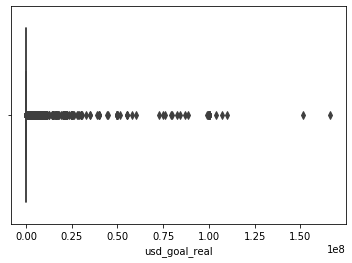

In [115]:
#データの中身確認
sns.boxplot(Kickstarter["usd_goal_real"])

In [116]:
#目的変数を成功と失敗のみ取り扱う
Kickstarter_s = Kickstarter[Kickstarter['state']=='successful']
Kickstarter_f=  Kickstarter[Kickstarter['state']=='failed']
Kickstarter = pd.concat([Kickstarter_s,Kickstarter_f])
Kickstarter['state'].value_counts()

failed        197716
successful    133956
Name: state, dtype: int64

In [117]:
#nameを数値型に変更する
def name_c(name):
    return len(str(name).split())
Kickstarter['name']=Kickstarter['name'].apply(name_c)

In [118]:
#stateを数値型に変更する
Kickstarter.loc[Kickstarter['state'] == "successful", 'state'] = 1
Kickstarter.loc[Kickstarter['state'] == "failed", 'state'] = 0
Kickstarter['state'].value_counts()
#nameを数値型に変更する
def state_t(state):
    return int(state)
Kickstarter['state']=Kickstarter['state'].apply(state_t)

In [119]:
#usd_goal_realを標準化する
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
Kickstarter["usd_goal_real"]=stdsc.fit_transform(Kickstarter[["usd_goal_real"]].values)

In [120]:
#時間を文字型から数値型に変更して、経過日数を計算
Kickstarter["launched"]= pd.to_datetime(Kickstarter["launched"])
Kickstarter["deadline"]= pd.to_datetime(Kickstarter["deadline"])
Kickstarter["keikanissuu"]=(Kickstarter["deadline"]-Kickstarter["launched"]).dt.days

In [121]:
Kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 5 to 378660
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   name           331672 non-null  int64         
 1   category       331672 non-null  object        
 2   main_category  331672 non-null  object        
 3   currency       331672 non-null  object        
 4   deadline       331672 non-null  datetime64[ns]
 5   launched       331672 non-null  datetime64[ns]
 6   state          331672 non-null  int64         
 7   country        331672 non-null  object        
 8   usd_goal_real  331672 non-null  float64       
 9   keikanissuu    331672 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 27.8+ MB


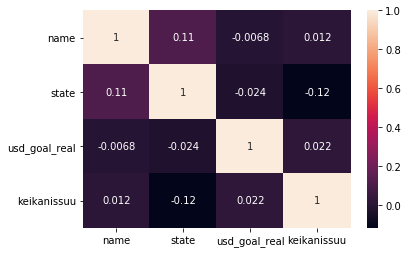

In [122]:
#現時点での相関を調べる
sns.heatmap(Kickstarter.corr(), annot=True)
plt.ylim(4, 0)
plt.show()


In [123]:
#不要な列の削除
#categoryは項目が多すぎるため、main_categoyを用いる
Kickstarter=Kickstarter.drop(columns="category")
Kickstarter=Kickstarter.drop(columns="deadline")
Kickstarter=Kickstarter.drop(columns="launched")

In [124]:
#ダミー変数の追加
Kickstarter=pd.get_dummies(Kickstarter,columns=["main_category"])
Kickstarter=pd.get_dummies(Kickstarter,columns=["currency"])
Kickstarter=pd.get_dummies(Kickstarter,columns=["country"])

In [125]:
#ロジスティック回帰で予測を行う
y=Kickstarter["state"].values
X=Kickstarter.drop("state",axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, )
clf.fit(X, y)
w0 = clf.intercept_[0]
w = clf.coef_

print(w0)
print(w)

-3.7622387937963477
[[ 1.49287537e-01 -1.20627706e+02  9.83329171e-03 -3.77063102e-01
   3.81064859e-01 -1.31104615e+00  5.89882420e-01  3.08622534e-01
  -8.61321273e-01  9.71014677e-02 -5.21096475e-01  2.42290539e-01
  -1.15108165e+00  4.32596648e-02 -7.52707313e-01 -7.67872166e-01
  -2.58903965e-01  5.76631814e-01 -4.69757464e-01 -1.48269390e-01
  -7.29217153e-02 -3.88522467e-01 -4.99917749e-01  1.90259123e-01
   1.86848026e-02 -2.33599812e-01 -6.42503562e-01 -4.27378276e-01
  -3.05174380e-01 -3.14637204e-01 -2.12710939e-01 -2.55789761e-01
  -4.01815999e-01 -3.02758075e-01 -1.76186348e-01 -4.64741118e-01
  -7.29217153e-02 -2.53307721e-01  5.07548294e-02 -3.98965872e-01
   3.32224801e-01 -5.42707368e-01  1.86848026e-02 -2.09408380e-01
  -7.53051195e-01 -2.33599812e-01  1.96375300e+00 -6.42503562e-01
  -1.87156199e-01 -2.64985381e-01 -4.92834709e-01 -3.05174380e-01
  -2.52539161e-01 -2.12710939e-01  3.97117083e-02]]


In [126]:
# ラベルを予測
y_est = clf.predict(X)

# 確率値を得る
y_est_proba = clf.predict_proba(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -269451.285
正答率 = 57.181%
適合率（Precision） = 48.211%
再現率（Recall） = 81.076%
F1値（F1-score） = 60.466%
